In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

## Calibration & Distortion Correction

The videos that we have are given by someone to create self-driving cars projects. He also gave a distortion calibration dataset for us to correct the lens distortion.

In [2]:
def calibrate_distortion():
    # Creating vector to store vectors of 3D points for each checkerboard image
    objpoints = []
    # Creating vector to store vectors of 2D points for each checkerboard image
    imgpoints = []
    
    # Prepare object points 0,0,0 ... 8,5,0 for 3D points
    obj_pts = np.zeros((6*9,3), np.float32)
    obj_pts[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Get directory for all calibration images
    images = glob.glob('camera_cal/*.jpg')

    for indx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

        if ret == True:
            objpoints.append(obj_pts)
            
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
            
            imgpoints.append(corners2)

    # Calibrate camera
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)
    
    # Save camera calibration for later use
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump( dist_pickle, open('camera_cal/cal_pickle.p', 'wb') )

In [3]:
calibrate_distortion()

In [4]:
def undistort(img, cal_dir='camera_cal/cal_pickle.p'):
    with open(cal_dir, mode='rb') as f:
        file = pickle.load(f)
    mtx = file['mtx']
    dist = file['dist']
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

Text(0.5, 1.0, 'Undistorted Image')

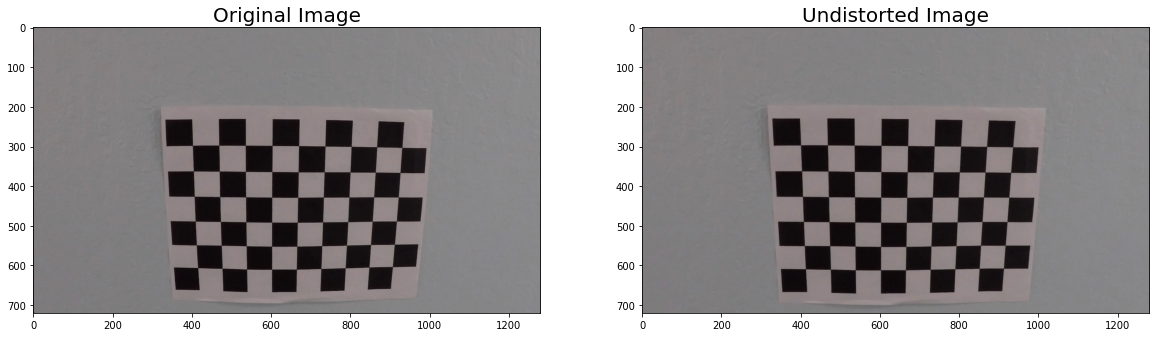

In [5]:
img = cv2.imread('camera_cal/calibration17.jpg')
dst = undistort(img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)

## Edges detection

In [6]:
img = cv2.imread('test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = undistort(img)

In [7]:
def detect_edges(img, s_thresh=(100, 255), sx_thresh=(15, 255), canny=True, blur=True):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    
    # Sobel x
    if canny:
        edges = cv2.Canny(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 70, 200)
    else:
        edges = cv2.Sobel(l_channel, cv2.CV_64F, 1, 1)
    
    abs_edges = np.absolute(edges) # Absolute x derivative to accentuate lines away from horizontal
    scaled_edges = np.uint8(255*abs_edges/np.max(abs_edges))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_edges)
    sxbinary[(scaled_edges >= sx_thresh[0]) & (scaled_edges <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    if blur:
        combined_binary = cv2.blur(combined_binary, (5,5))
    
    return combined_binary

Text(0.5, 1.0, 'Edges Image (Sobel / Blurry)')

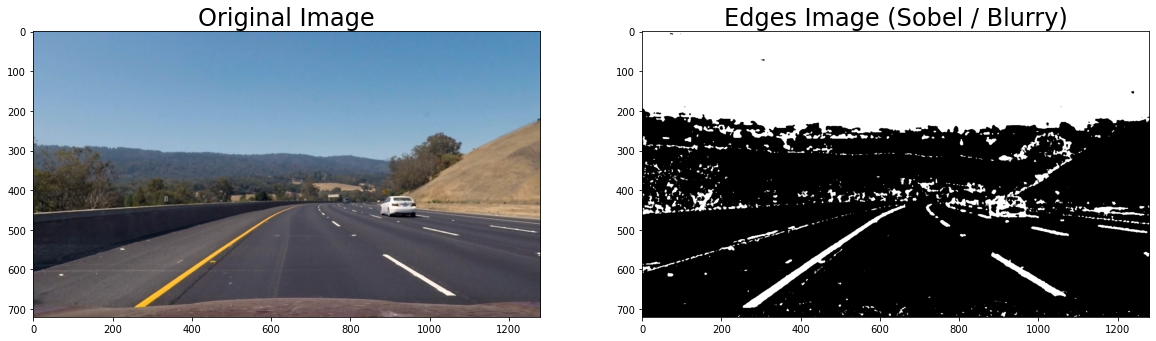

In [8]:
dst = detect_edges(img, canny=False, blur=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=24)
ax2.imshow(dst, cmap="gray")
ax2.set_title('Edges Image (Sobel / Blurry)', fontsize=24)

## Perspective warp

In [9]:
src_points = [(0,0.70),(1,0.70),(0,1),(1,1)]
dst_points = [(0,0), (1, 0), (0,1), (1,1)]
dst_shape = (1280, 720)

In [10]:
def perspective_warp(img):
    # Create real pixels poins from percentages proportions
    img_size = np.float32([(img.shape[1], img.shape[0])])
    src = np.float32(src_points) * img_size
    dst = np.float32(dst_points) * np.float32(dst_shape)
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, dst_shape)
    
    return warped

Text(0.5, 1.0, 'Warped Image')

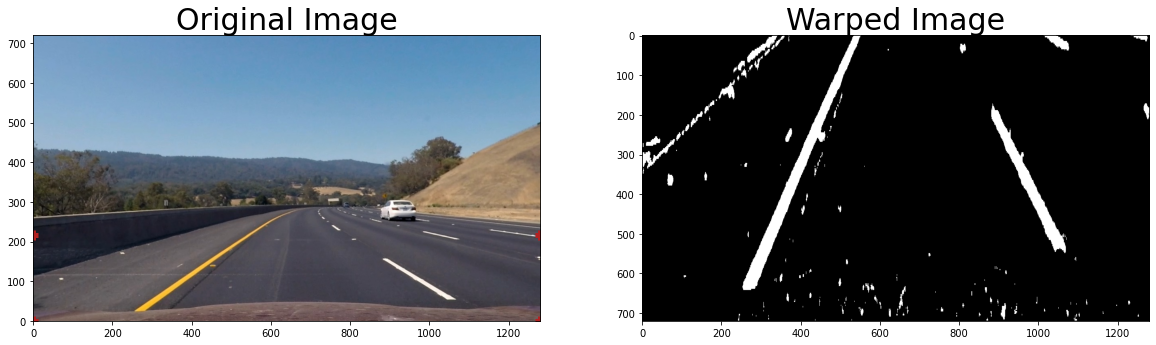

In [11]:
dst = perspective_warp(dst)

# Visualize perspective warp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img, extent=[0, 1280, 0, 720])
for point in src_points:
    ax1.plot(int(img.shape[1]*point[0]), int(720 - img.shape[0]*point[1]), '+', markersize=10, markeredgewidth=5, color='firebrick')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)

### Inverse function

In [12]:
def inv_perspective_warp(img):
    # Create real pixels poins from percentages proportions
    img_size = np.float32([(img.shape[1],img.shape[0])])
    src = np.float32(src_points) * img_size
    dst = np.float32(dst_points) * np.float32(dst_shape)
    
    M = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, dst_shape)
    return warped

## Lane detection

In [13]:
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

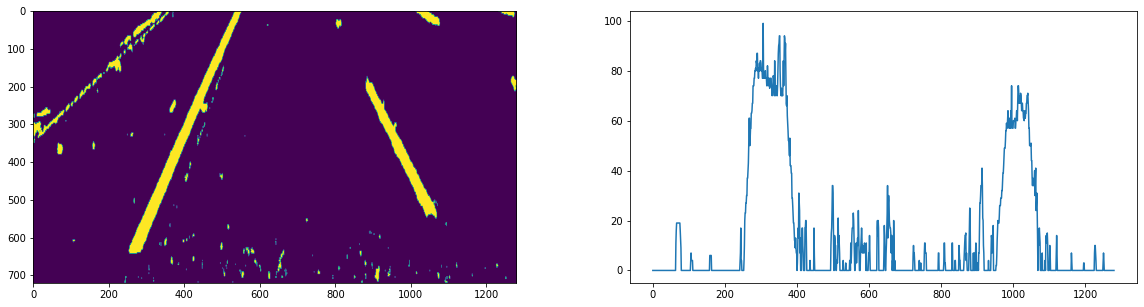

In [21]:
# Visualize perspective warp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.imshow(dst)
ax2.plot(get_hist(dst))

### Sharpen image

In [230]:
def sharp_image(image):
    # applying the sharpening kernel to the input image & displaying it.
    kernel = np.ones((5,5),np.uint8)
    sharpened = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return sharpened

Text(0.5, 1.0, 'Sharpened Image')

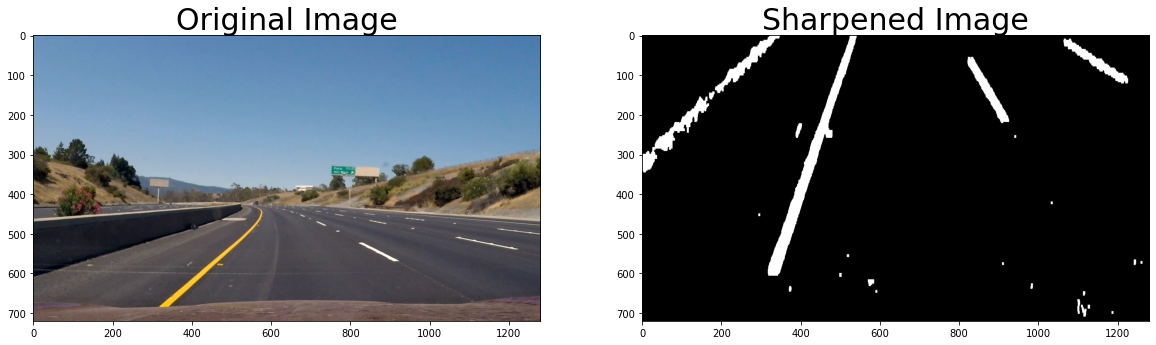

In [231]:
dst = sharp_image(dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Sharpened Image', fontsize=30)

### Lane fitting

In [232]:
left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]

def sliding_window(img, nwindows=9, margin=100, minpix = 1, draw_windows=True):
    global left_a, left_b, left_c,right_a, right_b, right_c 
    left_fit_= np.empty(3)
    right_fit_ = np.empty(3)
    out_img = np.dstack((img, img, img))*255

    histogram = get_hist(img)
    # find peaks of left and right halves
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_windows == True:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (255,255,100), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (100,255,255), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_a.append(left_fit[0])
    left_b.append(left_fit[1])
    left_c.append(left_fit[2])
    
    right_a.append(right_fit[0])
    right_b.append(right_fit[1])
    right_c.append(right_fit[2])
    
    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])
    left_fit_[2] = np.mean(left_c[-10:])
    
    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])
    right_fit_[2] = np.mean(right_c[-10:])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2]
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 100]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255]
    
    return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty

In [233]:
def draw_lanes(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    
    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    points = np.hstack((left, right))
    
    cv2.fillPoly(color_img, np.int_(points), (0, 200, 255))
    inv_perspective = inv_perspective_warp(color_img)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)
    return inv_perspective

Text(0.5, 1.0, 'Final Image')

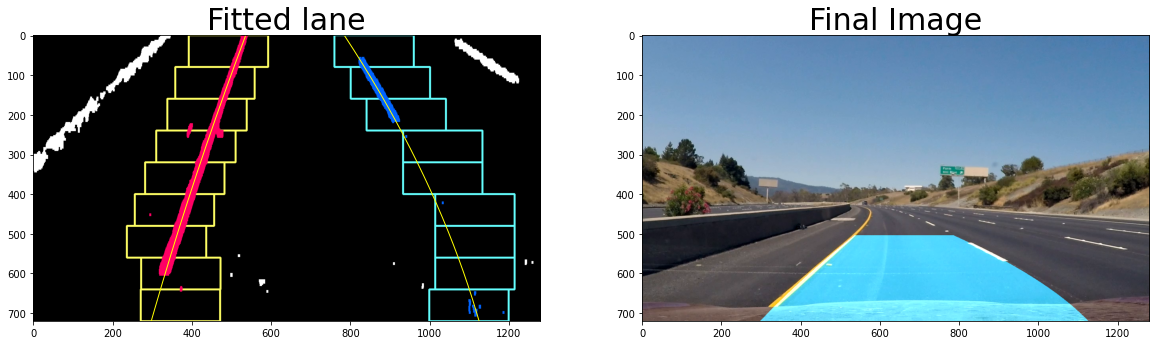

In [234]:
out_img, curves, lanes, ploty = sliding_window(dst, draw_windows=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(out_img)
ax1.plot(curves[0], ploty, color='yellow', linewidth=1)
ax1.plot(curves[1], ploty, color='yellow', linewidth=1)
ax1.set_title('Fitted lane', fontsize=30)

img_ = draw_lanes(img, curves[0], curves[1])
ax2.imshow(img_, cmap='hsv')
ax2.set_title('Final Image', fontsize=30)

## Final result

Text(0.5, 1.0, 'Final Image')

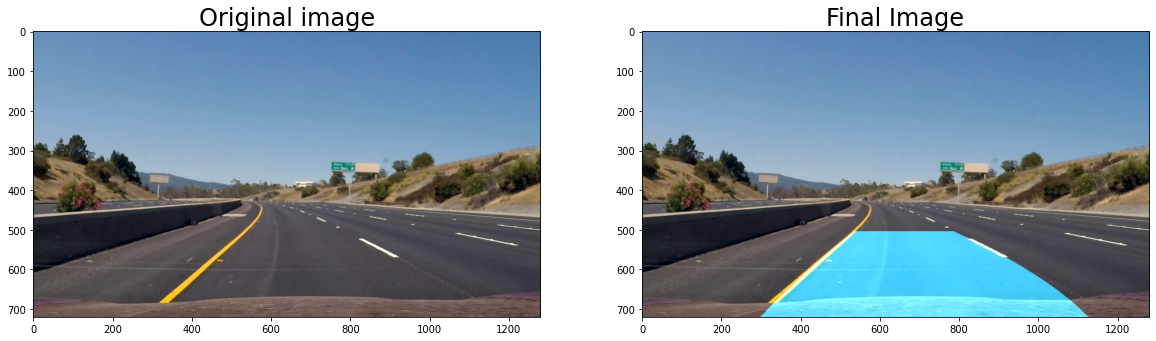

In [241]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original image', fontsize=24)
ax2.imshow(img_, cmap='hsv')
ax2.set_title('Final Image', fontsize=24)

## Video Pipeline

In [235]:
from moviepy.editor import VideoFileClip

In [237]:
def vid_pipeline(img):
    dst = undistort(img)
    dst = detect_edges(dst, canny=False, blur=True)
    dst = perspective_warp(dst)
    
    out_img, curves, lanes, ploty = sliding_window(dst, draw_windows=False)
    dst = draw_lanes(img, curves[0], curves[1])
    
    return dst

In [238]:
myclip = VideoFileClip('videos/easy_video.mp4')
output_vid = 'videos/easy_output.mp4'

In [239]:
clip = myclip.fl_image(vid_pipeline)
clip.write_videofile(output_vid, audio=False)

t:   0%|          | 2/1260 [00:00<01:27, 14.31it/s, now=None]

Moviepy - Building video videos/easy_output.mp4.
Moviepy - Writing video videos/easy_output.mp4




t:   1%|          | 13/1260 [09:48<01:01, 20.38it/s, now=None]  

Moviepy - Done !
Moviepy - video ready videos/easy_output.mp4


In [197]:
img = myclip.get_frame(0 * 1/25)